# System analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
debug=False

### 1) Load data from BIN files

In [3]:
wes_title='wes2015'
aida_title='aida'
rss_title='rss500'
reuters_title='reuters128'

In [4]:
### Load data from disk
import pickle
with open('%s_agdistis.bin' % aida_title, 'rb') as outfile:
    aida_agd_articles=pickle.load(outfile)
with open('%s_agdistis.bin' % wes_title, 'rb') as outfile:
    wes_agd_articles=pickle.load(outfile)
with open('%s_agdistis.bin' % rss_title, 'rb') as outfile:
    rss_agd_articles=pickle.load(outfile)
with open('%s_agdistis.bin' % reuters_title, 'rb') as outfile:
    reuters_agd_articles=pickle.load(outfile)
    
with open('%s_spotlight.bin' % aida_title, 'rb') as outfile:
    aida_spot_articles=pickle.load(outfile)
with open('%s_spotlight.bin' % wes_title, 'rb') as outfile:
    wes_spot_articles=pickle.load(outfile)
with open('%s_spotlight.bin' % rss_title, 'rb') as outfile:
    rss_spot_articles=pickle.load(outfile)
with open('%s_spotlight.bin' % reuters_title, 'rb') as outfile:
    reuters_spot_articles=pickle.load(outfile)    
    
with open('%s_wat.bin' % aida_title, 'rb') as outfile:
    aida_wat_articles=pickle.load(outfile)
with open('%s_wat.bin' % wes_title, 'rb') as outfile:
    wes_wat_articles=pickle.load(outfile)
with open('%s_wat.bin' % rss_title, 'rb') as outfile:
    rss_wat_articles=pickle.load(outfile)
with open('%s_wat.bin' % reuters_title, 'rb') as outfile:
    reuters_wat_articles=pickle.load(outfile)    

#### DEBUG: Store agdistis output to a file

In [5]:
if debug:
    with open('agdmag_aida_debug.tsv', 'w') as w:
        w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
        for article in aida_agd_articles:
            for mention in article.entity_mentions:
                if mention.sys_link.startswith('http://aksw.org/'):
                    mention.sys_link = '--NME--'

                a_row=[article.collection, str(article.identifier), 
                       str(mention.begin_index), str(mention.end_index), 
                       mention.mention, mention.gold_link, 
                       mention.sys_link]
                w.write('\t'.join(a_row) + '\n')

In [6]:
import utils
import plot_utils
import time
from collections import defaultdict

**1.1. Pick dataset**

In [7]:
print(type(aida_agd_articles))
#spot_articles=aida_spot_articles.union(wes_spot_articles)
#agd_articles=aida_agd_articles.union(wes_agd_articles)
spot_articles=rss_spot_articles | reuters_spot_articles | aida_spot_articles | wes_spot_articles
agd_articles=rss_agd_articles | reuters_agd_articles | aida_agd_articles | wes_agd_articles
wat_articles=rss_wat_articles | reuters_wat_articles | aida_wat_articles | wes_wat_articles

<class 'set'>


In [8]:
for col_articles in [aida_agd_articles, wes_agd_articles]:
    for article in col_articles:
        for mention in article.entity_mentions:
            if mention.sys_link.startswith('http://aksw.org/'):
                mention.sys_link = '--NME--'
            #a_row=[article.collection, str(article.identifier), 
            #           str(mention.begin_index), str(mention.end_index), 
            #           mention.mention, mention.gold_link, 
            #           mention.sys_link]
            #print('\t'.join(a_row))

### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [9]:
scores=[]
systems=['agdistis', 'spotlight', 'wat']
system_articles = {'agdistis': agd_articles, 'spotlight': spot_articles, 'wat': wat_articles}

In [10]:
skip_nils=True
skip_nonnils=False
print("AGDISTIS")
agd_acc=plot_utils.overall_performance(agd_articles, skip_nils, skip_nonnils)
scores.append(['overall', 'agdistis', agd_acc])
print(agd_acc)
print()
print("SPOTLIGHT")
spot_acc=plot_utils.overall_performance(spot_articles, skip_nils, skip_nonnils)
print(spot_acc)
scores.append(['overall', 'spotlight', spot_acc])
print("WAT")
wat_acc=plot_utils.overall_performance(wat_articles, skip_nils, skip_nonnils)
scores.append(['overall', 'wat', wat_acc])
print(wat_acc)
print()

AGDISTIS
25906 57578
0.4499287922470388

SPOTLIGHT
38889 57578
0.6754142207092987
WAT
27864 57578
0.4839348362221682



#### 2.2. Prepare forms subset to evaluate ambiguous forms

In [11]:
def compute_acc_on_selection(arts, forms_set):
    correct=0
    total=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                total+=1
                if entity.gold_link==entity.sys_link:
                    correct+=1
    print(correct, total)
    return correct/total

#### 2.3. Only forms that are interpretted as NILs and not-NILs

In [12]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_acc_on_selection(system_articles[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    scores.append(['forms with nils & non-nils', system, nn_f_acc])

1440 3536
agdistis 0.4072398190045249
1675 3536
spotlight 0.4736990950226244
2062 3536
wat 0.5831447963800905


#### 2.4. Only ambiguous forms

In [13]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_acc_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    scores.append(['ambiguous forms', system, amb_f_acc])

5620 15373
agdistis 0.365576009887465
9024 15373
spotlight 0.5870031874064919
7962 15373
wat 0.5179210303779354


In [14]:
scores

[['overall', 'agdistis', 0.4499287922470388],
 ['overall', 'spotlight', 0.6754142207092987],
 ['overall', 'wat', 0.4839348362221682],
 ['forms with nils & non-nils', 'agdistis', 0.4072398190045249],
 ['forms with nils & non-nils', 'spotlight', 0.4736990950226244],
 ['forms with nils & non-nils', 'wat', 0.5831447963800905],
 ['ambiguous forms', 'agdistis', 0.365576009887465],
 ['ambiguous forms', 'spotlight', 0.5870031874064919],
 ['ambiguous forms', 'wat', 0.5179210303779354]]

['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight' 'wat']
width: 0.19999999999999998
evaluation: overall
0.4499287922470388
0.6754142207092987
0.4839348362221682
evaluation: ambiguous forms
0.365576009887465
0.5870031874064919
0.5179210303779354
evaluation: forms with nils & non-nils
0.4072398190045249
0.4736990950226244
0.5831447963800905


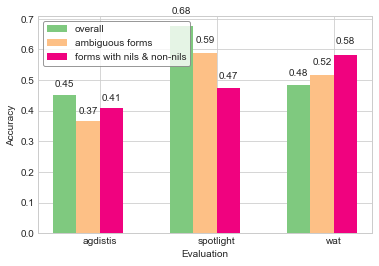

In [15]:
plot_utils.plot_scores(scores, title='Scores of systems')
#plot_scores(scores, title='Scores of systems')

### 3) Correlation between FORM frequency and accuracy

# Note: All stats from here on are on both datasets jointly

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

In [16]:
from scipy.stats import pearsonr, spearmanr

In [17]:
acc_by_form = {system: defaultdict(float) for system in systems}
for system in systems:
    acc_by_form[system], forms_by_count = plot_utils.compute_accuracy_by_form(
        system_articles[system], skip_nils)

In [18]:
import math

def counts_to_log_counts(forms_by_count):
    forms_by_log_count={}
    for count, forms in forms_by_count.items():
        try:
            log_count=math.log(count)
        except:
            print(count)
        forms_by_log_count[log_count] = forms
    return forms_by_log_count

forms_by_log_count=counts_to_log_counts(forms_by_count)

In [19]:
def lmplot(dist1, dist2):
    data={
        'form frequency': dist1,
        'accuracy': dist2
    }
    df=pd.DataFrame(data)
    ax = sns.lmplot(data=df, x='form frequency', y='accuracy', lowess=True)


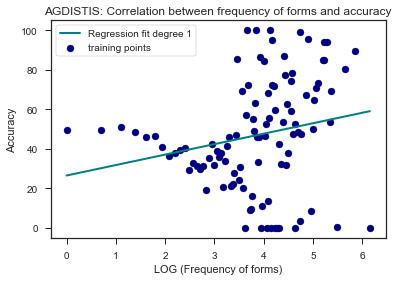

The Spearman correlation between X and Y is: 0.313269102194 . Significance:  0.00120358309649


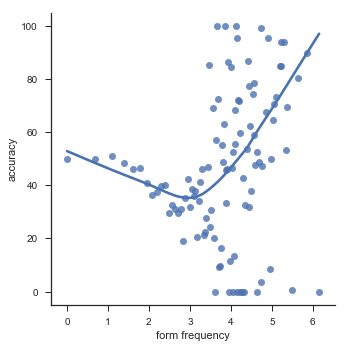

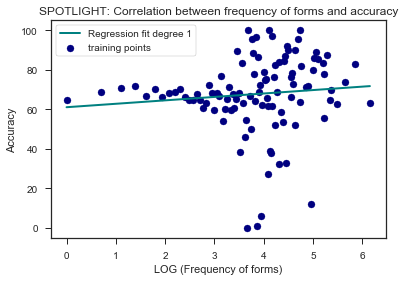

The Spearman correlation between X and Y is: 0.225565193283 . Significance:  0.0213196074971


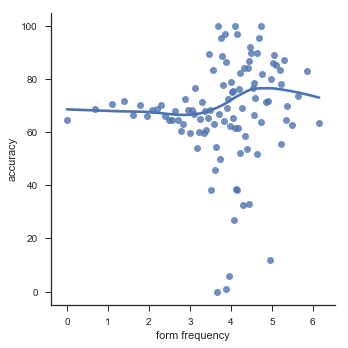

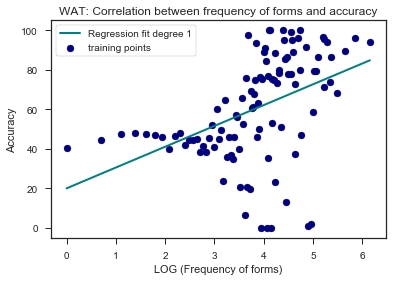

The Spearman correlation between X and Y is: 0.548004033393 . Significance:  1.73294441498e-09


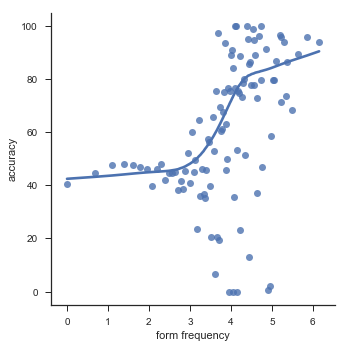

In [20]:
from collections import OrderedDict
import numpy as np
from scipy.stats import kendalltau
import pandas as pd
sns.set(style="ticks")

acc_by_freq={system: OrderedDict() for system in systems}

for system in systems:
        
    for count in sorted(forms_by_log_count.keys()):
        count_forms=forms_by_log_count[count]
        s=0
        for form in count_forms:
            s+=acc_by_form[system][form]
        acc_by_freq[system][count]=s/len(count_forms)
        
        
    dist1=np.array(list(acc_by_freq[system].keys()))
    dist2=np.array(list(acc_by_freq[system].values()))
    plot_utils.scatter_plot(dist1, dist2, 
                            title='%s: Correlation between frequency of forms and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of forms)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

#    fig = plt.figure()
#    sns.jointplot(dist1, dist2, kind="hex", stat_func=kendalltau, color="#4CB391")
#    fig.savefig('img/%s-ff-acc.png' % system)
    lmplot(dist1,dist2)
    
    
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 4) Entropy

In [21]:
from scipy.stats import entropy
form_entropies={}
for form in ambiguous_forms:
    counts=plot_utils.get_form_counts(spot_articles, form)
    counts=list(counts)
    form_entropies[form]=entropy(counts ,base=len(counts))

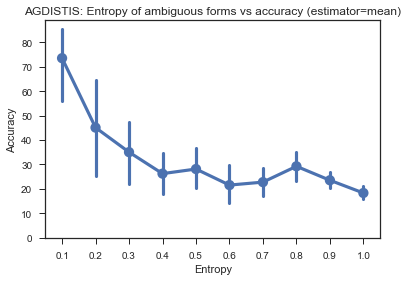

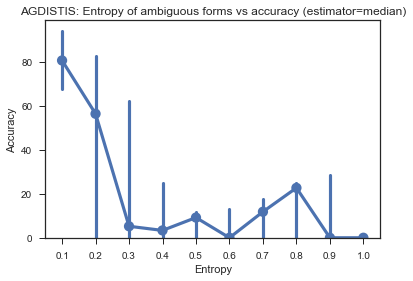

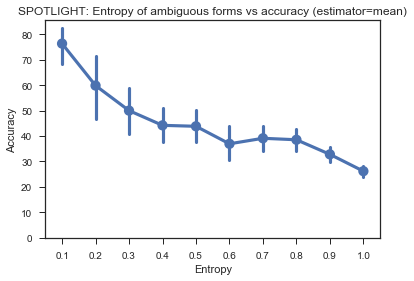

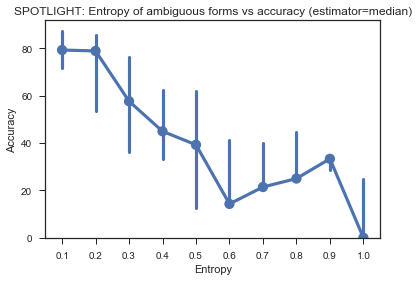

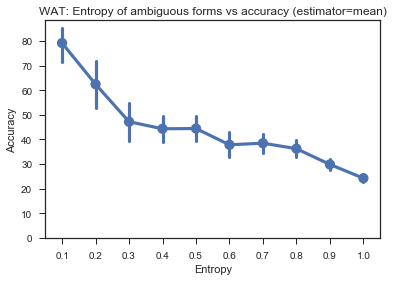

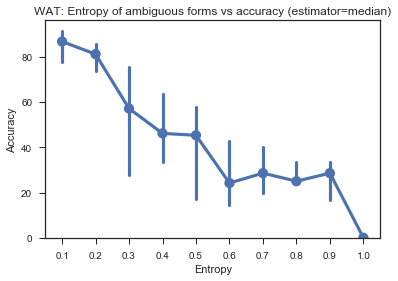

In [22]:
xs=[]
ys=[]
for system in systems:
    for form, entropy in form_entropies.items():
        xs.append(round(entropy,1))
        ys.append(acc_by_form[system][form])
        
    plot_utils.plot_line_with_whiskers(xs, ys,
                        title='%s: Entropy of ambiguous forms vs accuracy' % system.upper(),
                        xl='Entropy',
                        yl='Accuracy',
                        save=True)

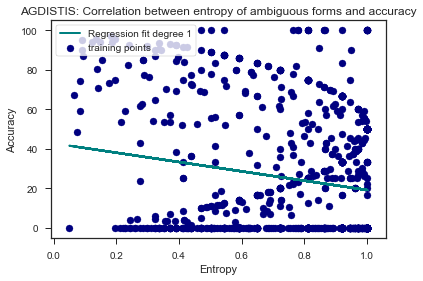

The Spearman correlation between X and Y is: -0.168483865075 . Significance:  2.39511591397e-08


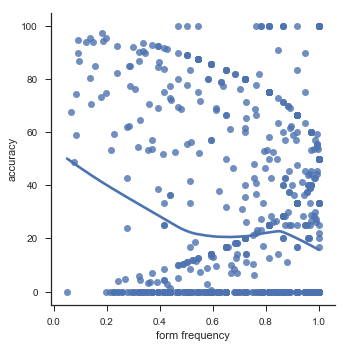

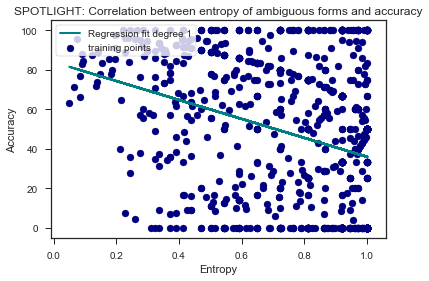

The Spearman correlation between X and Y is: -0.334825036496 . Significance:  8.31150894965e-30


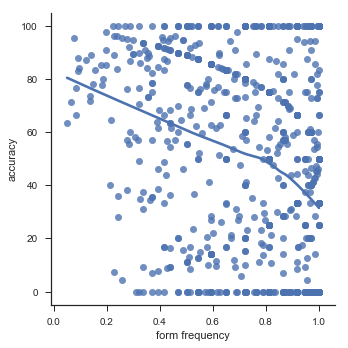

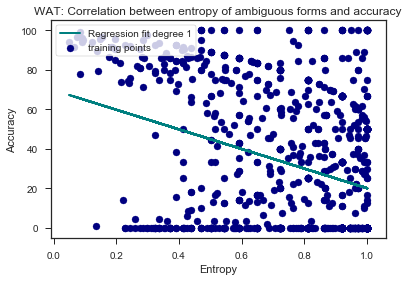

The Spearman correlation between X and Y is: -0.335598013104 . Significance:  6.04676306724e-30


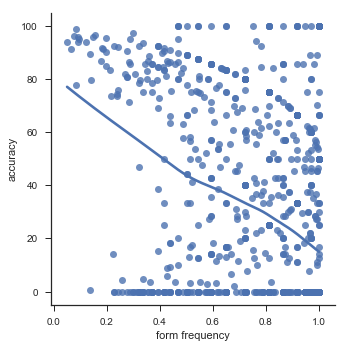

In [23]:
for system in systems:
    dist1=[]
    dist2=[]
    for f in ambiguous_forms:
        dist1.append(form_entropies[f])
        dist2.append(acc_by_form[system][f])

    dist1=np.array(dist1)
    dist2=np.array(dist2)
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between entropy of ambiguous forms and accuracy' % system.upper(),
                            x_axis='Entropy',
                            y_axis='Accuracy',
                            save=True
                            )

    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
    
    #fig = plt.figure()
    #sns.jointplot(dist1, dist2, kind="hex", stat_func=kendalltau, color="#4CB391")
    #
    #fig.savefig('img/%s-ff-acc.png' % system)
    
    lmplot(dist1, dist2)

### 5) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

In [24]:
acc_by_uri = {system: defaultdict(float) for system in systems}
for system in systems:
    acc_by_uri[system], uris_by_count = plot_utils.compute_accuracy_by_uri(
        system_articles[system], skip_nils)

In [25]:
uris_by_log_count=counts_to_log_counts(uris_by_count)

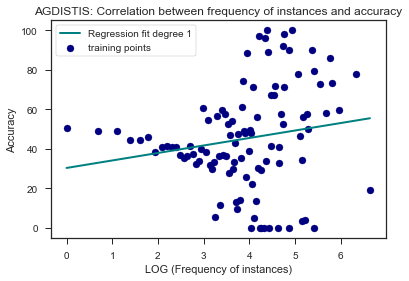

The Spearman correlation between X and Y is: 0.234844671024 . Significance:  0.0164097847595


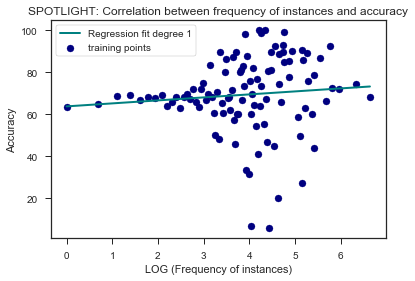

The Spearman correlation between X and Y is: 0.196581128191 . Significance:  0.0454923583454


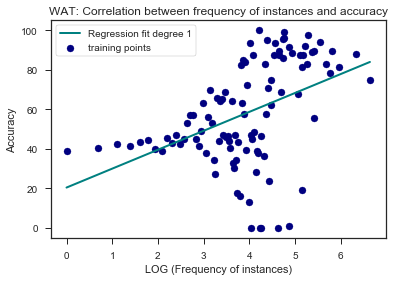

The Spearman correlation between X and Y is: 0.512236302897 . Significance:  2.72485071129e-08


In [26]:
acc_by_freq_uris={system: OrderedDict() for system in systems}

for system in systems:
        
    for count in sorted(uris_by_log_count.keys()):
        count_uris=uris_by_log_count[count]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_freq_uris[system][count]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_freq_uris[system].keys()))
    dist2=np.array(list(acc_by_freq_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of instances and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 6) Correlation between instance PageRank and accuracy

In [27]:
skip_zeros=True

In [28]:
uris_by_pr = defaultdict(set)
uri_pr={}
for article in spot_articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            pagerank=int(entity.gold_pr)
            if skip_zeros and pagerank==0: continue
            uris_by_pr[pagerank].add(entity.gold_link)
            uri_pr[entity.gold_link]=entity.gold_pr

In [29]:
uris_by_log_pr=counts_to_log_counts(uris_by_pr)

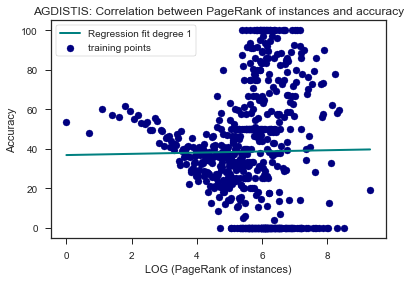

The Spearman correlation between X and Y is: 0.0196375008913 . Significance:  0.626369448149


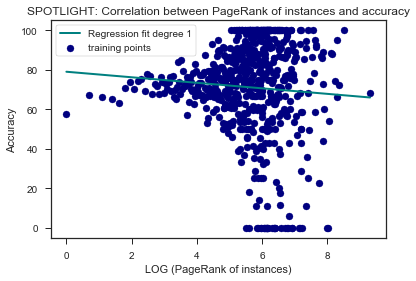

The Spearman correlation between X and Y is: 0.0285422585265 . Significance:  0.479143067294


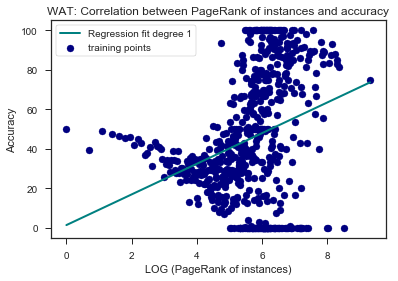

The Spearman correlation between X and Y is: 0.314360328164 . Significance:  1.28201223106e-15


In [30]:
acc_by_pr_uris={system: OrderedDict() for system in systems}

for system in systems:
        
    for pr in sorted(uris_by_log_pr.keys()):


        count_uris=uris_by_log_pr[pr]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_pr_uris[system][pr]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_pr_uris[system].keys()))
    dist2=np.array(list(acc_by_pr_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between PageRank of instances and accuracy' % system.upper(),
                            x_axis='LOG (PageRank of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 7) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [31]:
interpretations=defaultdict(set)
for article in spot_articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [32]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [33]:
def compute_ct_per_form(systems, system_articles, ambiguous_only=True, skip_nils=True):
    correct_per_form={system: defaultdict(dict) for system in systems}
    total_per_form={system: defaultdict(dict) for system in systems}
    for system in systems:
        for article in system_articles[system]:
            for mention in article.entity_mentions:
                form=mention.mention
                meaning=mention.gold_link
                if skip_nils and meaning=='--NME--':
                    continue
                if ambiguous_only and form not in ambiguous_forms:
                    continue
                if meaning not in total_per_form[system][form]:
                    total_per_form[system][form][meaning]=0
                    correct_per_form[system][form][meaning]=0
                total_per_form[system][form][meaning]+=1
                if meaning==mention.sys_link:
                    correct_per_form[system][form][meaning]+=1
    return correct_per_form, total_per_form

In [34]:
correct_per_form, total_per_form=compute_ct_per_form(systems, system_articles)

defaultdict(<class 'int'>, {1: 11853, 2: 2606, 3: 475, 4: 119, 5: 36, 6: 14, 7: 4, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1})
defaultdict(<class 'float'>, {1: 0.4178688939508985, 2: 0.21220260936300844, 3: 0.1368421052631579, 4: 0.01680672268907563, 5: 0.05555555555555555, 6: 0.14285714285714285, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


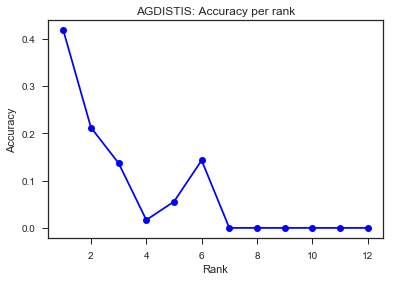

The Spearman correlation between X and Y is: -0.884562387349 . Significance:  0.000132600665866
defaultdict(<class 'int'>, {1: 11853, 2: 2606, 3: 475, 4: 119, 5: 36, 6: 14, 7: 4, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1})
defaultdict(<class 'float'>, {1: 0.6504682358896482, 2: 0.4155794320798158, 3: 0.3473684210526316, 4: 0.3697478991596639, 5: 0.2222222222222222, 6: 0.21428571428571427, 7: 0.0, 8: 1.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


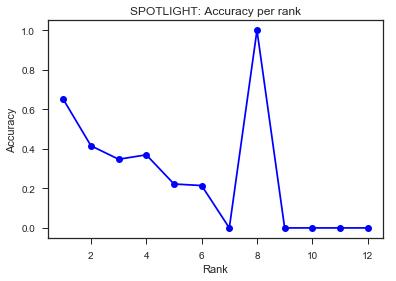

The Spearman correlation between X and Y is: -0.739616059488 . Significance:  0.00596951924605
defaultdict(<class 'int'>, {1: 11853, 2: 2606, 3: 475, 4: 119, 5: 36, 6: 14, 7: 4, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1})
defaultdict(<class 'float'>, {1: 0.5952079642284653, 2: 0.2812739831158864, 3: 0.2063157894736842, 4: 0.16806722689075632, 5: 0.1111111111111111, 6: 0.2857142857142857, 7: 0.0, 8: 0.0, 9: 0.5, 10: 0.0, 11: 0.0, 12: 0.0})


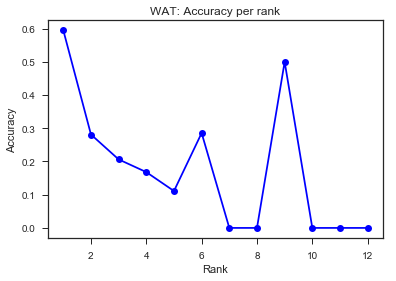

The Spearman correlation between X and Y is: -0.667104681107 . Significance:  0.0177976558063


In [35]:
for system in systems:
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form[system], total_per_form[system])
#    print(correct_per_rank)
    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank' % system.upper(), save=True)
    


### 8) Ranks of the top-N most frequent forms

<span style="background-color:lightgreen">Section 6.5. of the paper</span>


Germany
German
France
Russia
U.S.
Italy
Australia
Britain
England
Spain
defaultdict(<class 'float'>, {1: 0.6427947598253275, 2: 0.01775147928994083, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.0})


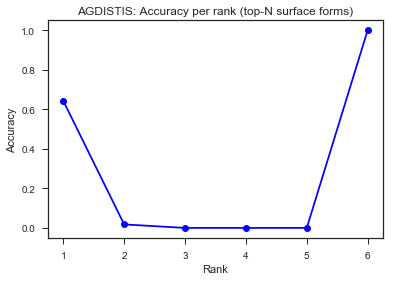

The Spearman correlation between X and Y is: -0.0303588370359 . Significance:  0.954475734694
Germany
German
England
U.S.
Spain
France
Australia
Russia
Britain
Italy
defaultdict(<class 'float'>, {1: 0.7087336244541484, 2: 0.8461538461538461, 3: 0.7878787878787878, 4: 0.631578947368421, 5: 0.0, 6: 1.0})


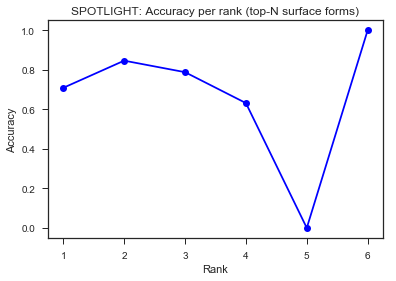

The Spearman correlation between X and Y is: 0.0285714285714 . Significance:  0.95715451895
U.S.
France
Australia
Britain
Russia
Spain
Germany
Italy
German
England
defaultdict(<class 'float'>, {1: 0.9148471615720524, 2: 0.4911242603550296, 3: 0.48484848484848486, 4: 0.631578947368421, 5: 0.0, 6: 0.0})


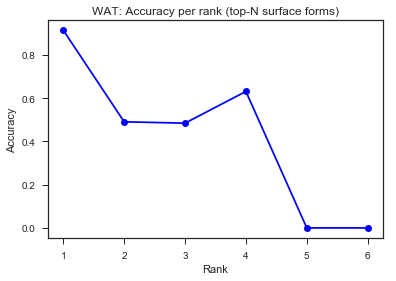

The Spearman correlation between X and Y is: -0.811679449913 . Significance:  0.0498575851013


In [36]:
# Top 10 have form frequency of >135
min_frequency=170
for system in systems:
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form[system], 
                                                                total_per_form[system], 
                                                                min_frequency=min_frequency)
#    print(correct_per_rank)
#    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank (top-N surface forms)' % system.upper(), save=True)
    


#### The reason for the peak in form 3 is NEW YORK, where the state is third most common in the corpus

In [37]:
form='England'
print(total_per_form[form])
print(correct_per_form[form])

KeyError: 'England'

In [ ]:
form='Germany'
print(total_per_form[form])
print(correct_per_form[form])

#### What is going on with China?

In [ ]:
for a in spot_articles:
    for m in a.entity_mentions:
        if m.mention=='China':
            print(m.gold_link, m.sys_link)

### 7) PageRank analysis

<span style="background-color:lightgreen">Section 6.6. of the paper</span>

In [38]:
uri_pr

{'CBS_Sports': 17.9252,
 'Boomer_Esiason': 4.7797,
 'Georg_Simmel': 12.7286,
 'Max_Weber': 74.991,
 'Émile_Durkheim': 36.7062,
 'Denver': 248.8854,
 'Aurora,_Colorado': 18.7317,
 'Football_Association_of_Ireland': 16.1375,
 'Giovanni_Trapattoni': 6.1175,
 'Ion_Iliescu': 9.4958,
 'Hungary': 802.5039,
 'Bucharest': 203.2995,
 'Romania': 1650.548,
 'Social_Democratic_Party_(Romania)': 36.3812,
 'Romanian_National_Unity_Party': 1.8596,
 'Adrian_Năstase': 3.4509,
 'NATO': 411.3501,
 'European_Union': 1114.9956,
 'United_States': 11066.2733,
 'New_York_City': 2057.7607,
 'World_War_II': 4022.0724,
 'Germany': 3766.7304,
 'Poland': 2057.1688,
 'Warsaw': 448.1065,
 'Polish_Press_Agency': 1.2387,
 'Interior_ministry': 45.4677,
 'Helmut_Kohl': 25.4299,
 'Socrates': 91.8607,
 'Greeks': 247.3388,
 'Philosopher': 127.3258,
 'Western_philosophy': 51.8649,
 'Philosophy': 416.3321,
 'Writer': 89.3486,
 'Plato': 244.6975,
 'Xenophon': 51.1689,
 'Pre-Socratic_philosophy': 21.8524,
 'Attempt': 4.8807,
 '

In [39]:
acc_by_form

{'agdistis': defaultdict(int,
             {'Hu': 100.0,
              'Jang': 0.0,
              'SCOTTISH': 0.0,
              'GLASGOW': 100.0,
              'Scottish': 0.0,
              'Rangers': 100.0,
              'Celtic': 0.0,
              'Aberdeen': 0.0,
              'Hearts': 0.0,
              'Hibernian': 100.0,
              'Dundee United': 100.0,
              'Motherwell': 0.0,
              'Dunfermline': 0.0,
              'Raith': 16.666666666666668,
              'Kilmarnock': 0.0,
              'St Johnstone': 0.0,
              'Falkirk': 0.0,
              'Airdrieonians': 100.0,
              'Dundee': 22.22222222222222,
              'Partick': 0.0,
              'St Mirren': 100.0,
              'Greenock Morton': 100.0,
              'Clydebank': 0.0,
              'Stirling': 0.0,
              'East Fife': 100.0,
              'Ayr': 0.0,
              'Livingston': 100.0,
              'Hamilton': 14.285714285714286,
              'Clyde': 0.0,
    

defaultdict(<class 'int'>, {1: 4926, 2: 546, 3: 52, 4: 22, 5: 2, 6: 0, 7: 4, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
defaultdict(<class 'int'>, {1: 9823, 2: 3824, 3: 822, 4: 171, 5: 117, 6: 31, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.5014761274559707, 2: 0.14278242677824268, 3: 0.06326034063260341, 4: 0.1286549707602339, 5: 0.017094017094017096, 6: 0.0, 7: 0.4444444444444444, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


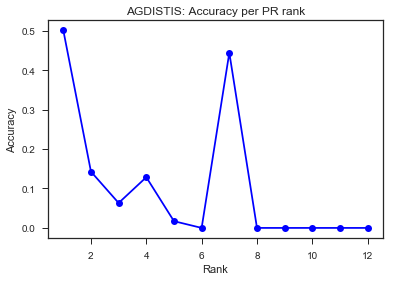

The Spearman correlation between X and Y is: -0.798718780138 . Significance:  0.0018354045665
defaultdict(<class 'int'>, {1: 6720, 2: 1898, 3: 219, 4: 57, 5: 88, 6: 13, 7: 2, 8: 0, 9: 0, 10: 0, 11: 5, 12: 0})
defaultdict(<class 'int'>, {1: 9823, 2: 3824, 3: 822, 4: 171, 5: 117, 6: 31, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.6841087244222742, 2: 0.4963389121338912, 3: 0.2664233576642336, 4: 0.3333333333333333, 5: 0.7521367521367521, 6: 0.41935483870967744, 7: 0.2222222222222222, 8: 0.0, 9: 0.0, 10: 0.0, 11: 1.0, 12: 0.0})


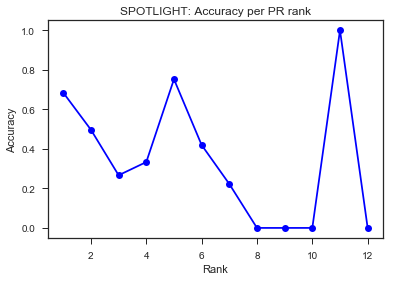

The Spearman correlation between X and Y is: -0.466265989365 . Significance:  0.126534787903
defaultdict(<class 'int'>, {1: 6608, 2: 1071, 3: 107, 4: 41, 5: 51, 6: 9, 7: 1, 8: 0, 9: 0, 10: 2, 11: 0, 12: 0})
defaultdict(<class 'int'>, {1: 9823, 2: 3824, 3: 822, 4: 171, 5: 117, 6: 31, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.6727069123485697, 2: 0.2800732217573222, 3: 0.13017031630170317, 4: 0.23976608187134502, 5: 0.4358974358974359, 6: 0.2903225806451613, 7: 0.1111111111111111, 8: 0.0, 9: 0.0, 10: 0.4, 11: 0.0, 12: 0.0})


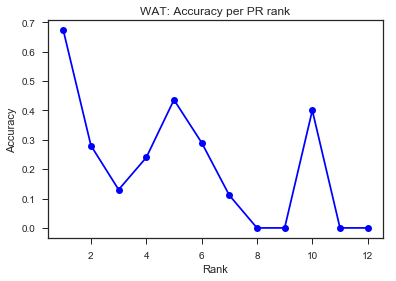

The Spearman correlation between X and Y is: -0.633552260359 . Significance:  0.0269747471005


In [40]:
#acc_per_form_meaning={'agdistis': {}, 'spotlight': {}}
for system in systems:
    correct_per_rank_pr=defaultdict(int)
    total_per_rank_pr=defaultdict(int)
    for form, meanings in total_per_form[system].items():
        #for uri, total in meanings.items():
            #acc_per_form_meaning[system][form][uri]=correct_per_form[form][uri]/total
        form_pageranks=[]
        for uri in meanings.keys():
            if uri in uri_pr:
                form_pageranks.append(tuple((uri_pr[uri], uri)))
        form_pageranks = sorted(form_pageranks, reverse=True)
        for rank in range(1,len(form_pageranks)+1):
            correct_per_rank_pr[rank]+=correct_per_form[system][form][form_pageranks[rank-1][1]]
            total_per_rank_pr[rank]+=total_per_form[system][form][form_pageranks[rank-1][1]]

    print(correct_per_rank_pr)
    print(total_per_rank_pr)
    plot_utils.plot_ranks(correct_per_rank_pr, total_per_rank_pr, 
                          title='%s: Accuracy per PR rank' % system.upper(), save=True)


### 8) Ambiguity and frequency together against accuracy

In [41]:
def heatmap_me(AMB, FREQ, ACC, system):
    data = pd.DataFrame({'AMB': AMB, 'FREQ': FREQ, 'ACC': ACC})
    data_pivoted = data.pivot("FREQ", "AMB", "ACC")
    fig=plt.figure(figsize = (12,7))
    ax = sns.heatmap(data_pivoted, annot=True, cmap="YlGnBu", linewidths=.5)
    ax.set_title(system.upper())
    for _, spine in ax.spines.items():
        spine.set_edgecolor('darkblue')
        spine.set_visible(True)
    plt.show()
    fig.savefig('img/%s_amb_frequency_acc.png' % system)

In [42]:
correct_per_form_all, total_per_form_all = compute_ct_per_form(systems, system_articles, ambiguous_only=False)

In [43]:
correct_per_form_all

{'agdistis': defaultdict(dict,
             {'Hu': {'Hu_Jintao': 1},
              'Jang': {'Jang_Sung-taek': 0},
              'SCOTTISH': {'Scotland': 0,
               'Scotland_national_football_team': 0},
              'GLASGOW': {'Glasgow': 9},
              'Scottish': {'Scotland': 0,
               'Scotland_national_football_team': 0,
               'Scottish_Gaelic': 0,
               'Scottish_people': 0},
              'Rangers': {'Rangers_F.C.': 10, 'Texas_Rangers_(baseball)': 3},
              'Celtic': {'Celtic_F.C.': 0},
              'Aberdeen': {'Aberdeen_F.C.': 0},
              'Hearts': {'Heart_of_Midlothian_F.C.': 0},
              'Hibernian': {'Hibernian_F.C.': 6},
              'Dundee United': {'Dundee_United_F.C.': 6},
              'Motherwell': {'Motherwell_F.C.': 0},
              'Dunfermline': {'Dunfermline_Athletic_F.C.': 0},
              'Raith': {'Raith_Rovers_F.C.': 1},
              'Kilmarnock': {'Kilmarnock_F.C.': 0},
              'St Johnstone'

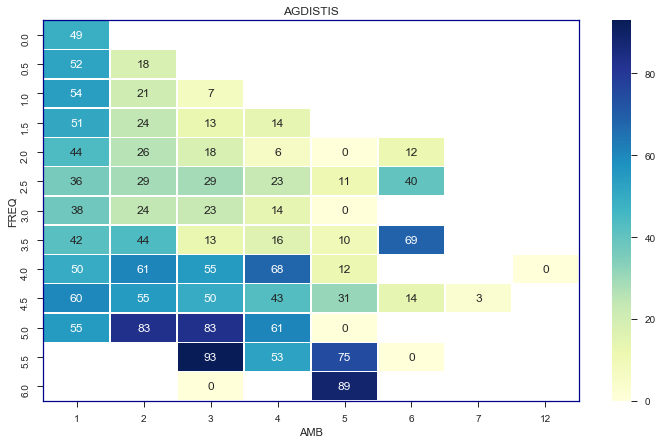

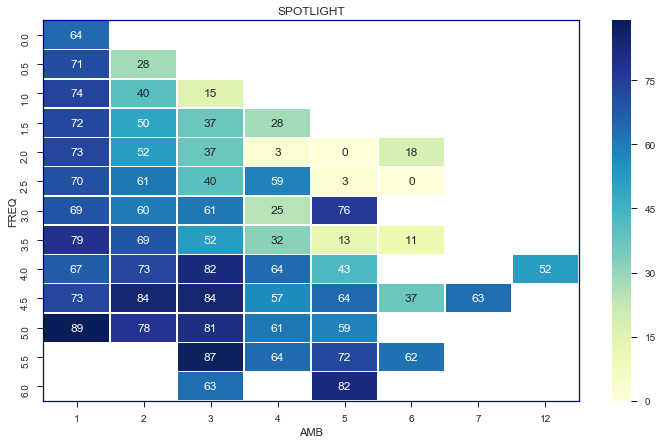

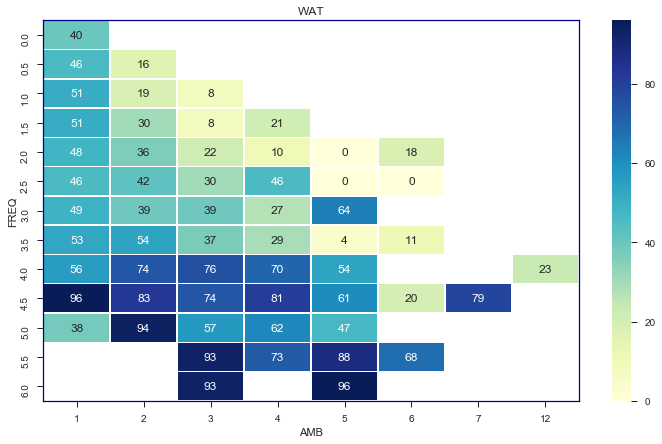

In [44]:

for system in systems:
    c=defaultdict(int)
    t=defaultdict(int)

    for log_freq, forms in forms_by_log_count.items():
        for form in forms:
#            if form not in ambiguous_forms:
#                continue
            total=sum(total_per_form_all[system][form].values())
            correct=sum(correct_per_form_all[system][form].values())
            acc=correct*100.0/total

            amb=ambiguity[form]

            rounded_freq=round(log_freq * 2) / 2

            c[(amb, rounded_freq)]+=correct
            t[(amb, rounded_freq)]+=total

    AMB=[]
    FREQ=[]
    ACC=[]

    for tpl, correct in c.items():
        total=t[tpl]
        acc=int(correct*100/total)
        ACC.append(acc)
        AMB.append(tpl[0])
        FREQ.append(tpl[1])
    heatmap_me(AMB, FREQ, ACC, system)

In [45]:
# library
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(df):

    # Make the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
    plt.show()

    # to Add a color bar which maps values to colors.
#    surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
#    fig.colorbar( surf, shrink=0.5, aspect=5)
#    plt.show()


#    # Other palette
    ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.jet, linewidth=0.01)
    plt.show()

plot_3d(data)

NameError: name 'data' is not defined

### 8) Notes

* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference